In [1]:
# %pip install lime
# !pip install --upgrade scikit-image


In [2]:
import numpy as np
import pandas as pd
from keras.models import load_model
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
from tensorflow.keras.datasets import mnist
from lime.wrappers.scikit_image import SegmentationAlgorithm
import skimage
from skimage.color import label2rgb

In [3]:
# Cargamos el modelo guardado.
cnn_minist = load_model('cnn_minist.h5')

# Comprobamos que se ha cargado bien visualizando la secuencia de capas.
cnn_minist.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 128)         12845184  
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0

Keras tiene el conjunto de datos MNIST como parte de su distribución, el cual se puede cargar utilizando el método load_data() del módulo mnist. Este método devuelve dos tuplas que representan los datos de entrenamiento y prueba organizados para el aprendizaje supervisado, por lo que hemos utilizado x e y para representar la imagen y la etiqueta objetivo, respectivamente.

Ahora bien, la imagen devuelta es un vector numpy unidimensional de tamaño 784, que se convierte de entero a float32 y se transforma en una matriz bidimensional de tamaño 28x28. Dado que la imagen es en escala de grises, los valores de sus píxeles van desde 0 hasta 255, por lo tanto, la normalizamos dividiéndolos por 255.0. Este paso es una etapa de preprocesamiento importante, ya que los números grandes aumentan la complejidad del entrenamiento, por lo tanto, se recomienda normalizarlos entre 0 y 1.

In [4]:
# Cargamos los datos de entrenamiento y prueba en sendos arrays.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1,28,28,1)).astype('float32') / 255.0
X_test = X_test.reshape((-1,28,28,1)).astype('float32') / 255.0

Dado que el módulo "lime" que estamos utilizando solo funciona con imágenes de 3 dimensiones, es decir, imágenes que tienen 3 canales generalmente RGB, aquí replicamos el plano de escala de grises. Este segmento de código convierte una imagen en escala de grises a RGB simplemente replicando el plano disponible.

In [5]:
# Creamos la función de conversión al tipo RGB.
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

# La aplicamos a los dos data sets.
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

In [6]:
print(X_train.shape, X_test.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


"y_train" almacena la etiqueta real de cada imagen en el conjunto de datos de entrenamiento.

In [7]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Ahora obtenemos "y_pred_train", que almacena las predicciones del modelo sobre los datos de imagen de entrenamiento, "X_train". La predicción por imagen es un vector unidimensional de 10 números y extraemos la etiqueta encontrando la posición del índice del número con el valor máximo. Luego, comparamos las etiquetas predichas y reales, y contamos el número de predicciones incorrectas.

In [8]:
# Obtenemos las predicciones sobre el conjunto de entrenamiento.
y_pred_train = cnn_minist.predict(X_train)

# La comparamos con las etiquetas originales.
bad_predictions = (y_pred_train.argmax(axis=1) != y_train)

# Las publicamos en pantalla.
print('Bad predictions:', sum(bad_predictions))

1875/1875 [==============================] - 377s 201ms/step
Bad predictions: 479


Nuestro modelo está listo y es hora de usar LIME para la Explicabilidad de la Inteligencia Artificial (XAI, por sus siglas en inglés). Utilizando el módulo "lime_image" del paquete LIME, creamos un objeto "explainer" de la clase "LimeImageExplainer()". Este objeto tiene un método llamado "explain_instance()" que toma datos de imagen tridimensionales y una función predictor, en este caso "model.predict". Basándose en las predicciones realizadas por la función predict del modelo, devuelve una explicación.

El objeto "explanation" tiene un método llamado "get_image_and_mask()" que toma las etiquetas predichas correspondientes a los datos de imagen tridimensionales analizados anteriormente y los devuelve como una tupla "(image, mask)", donde la imagen es un array numpy tridimensional y la máscara es un array numpy bidimensional que se puede usar con "skimage.segmentation.mark_boundaries". La imagen devuelta junto con la máscara correspondiente representa las características en la imagen responsables de la predicción.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


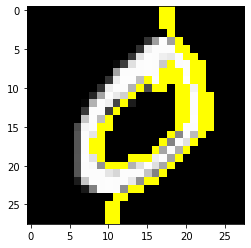

In [9]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(X_train[1], cnn_minist.predict)
plt.imshow(X_train[1])
temp, mask = explanation.get_image_and_mask(cnn_minist.predict(X_train[1].reshape((1,28,28,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

In [10]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [11]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = cnn_minist.predict, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 82ms/step
CPU times: total: 5min 26s
Wall time: 2min 51s


Text(0.5, 1.0, 'Positive/Negative Regions for 7')

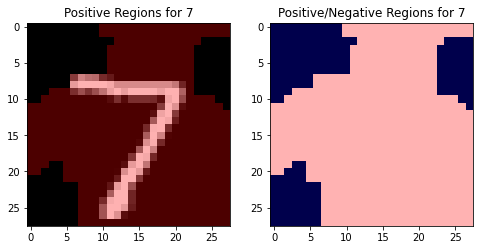

In [12]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

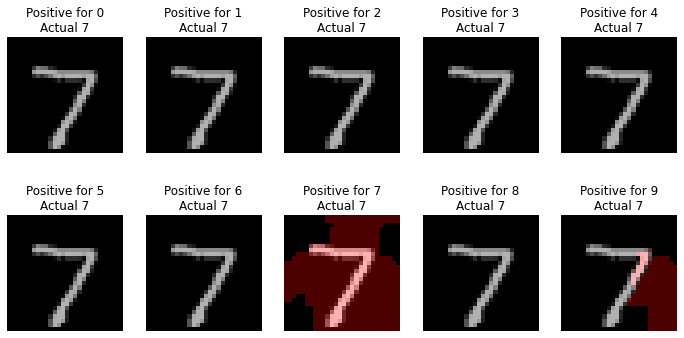

In [13]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

In [14]:
y_test[0]

7

In [15]:
pipe_pred_test = cnn_minist.predict(X_test)

wrong_idx = np.random.choice(np.where(pipe_pred_test.argmax(axis=1)!=y_test)[0])
pred =  pipe_pred_test[wrong_idx].argmax(axis=0)
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pred))

313/313 [==============================] - 67s 215ms/step
Using #2040 where the label was 5 and the pipeline predicted 6


In [16]:
y_test[wrong_idx]

5

In [17]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = cnn_minist.predict, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 95ms/step
CPU times: total: 5min 42s
Wall time: 3min 1s


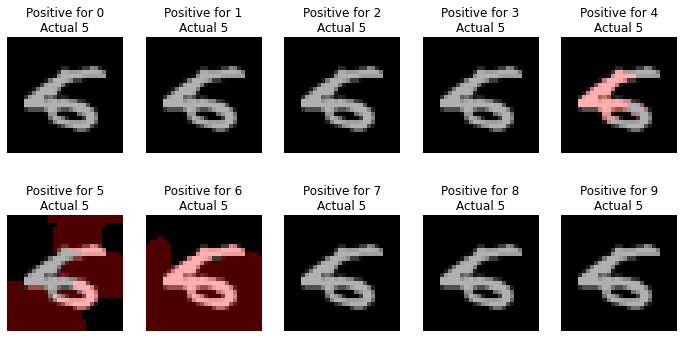

In [18]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')